This is a simple initial model to check a baseline accuracy. The data preparation step is more complex, as it uses a python generator to create strips of data to be fed into the CNN.

#### Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive', force_remount = True)

Mounted at /gdrive


#### Packages

In [ ]:
import pandas as pd
import numpy as np
import os
import tempfile
from datetime import datetime
from PIL import Image, ImageEnhance
import cv2
import matplotlib.pyplot as plt
from math import sqrt,exp
from google.colab.patches import cv2_imshow
from sklearn.utils import shuffle
import helper as hp

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split

Make sure to change the working directory to where the project is saved in Google Drive

In [ ]:
project_dir = "/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/"
working_dir = project_dir + "/SRC"
image_dir = project_dir + "data/images_cleaned/"
%cd {working_dir} 
%pwd

/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/SRC


'/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/SRC'

#### Load Metadata

To aid with data balancing, ages have been put into bins

In [ ]:
data = pd.read_csv(project_dir + 'data/clean_meta.csv')
print(data.shape)
bins = [0, 20, 30, 40, 50, 60, 70, 80, 100]
group_names = ['<19', '20 - 29', '30-39', '40-49','50-59','60-69','70-79','80-99']
data['age_groups'] = pd.cut(data['Age'], bins, labels=group_names)
data = data.drop('Unnamed: 0', axis= 1)
data.head(10)

(698, 8)


,ID,Tooth.Code,Age,Sex,ImgID,ImgName,eruption,age_groups
0,2,12.0,46.00,2.0,140,002_12_2_46_0140.tif,8.5,40-49
1,2,12.0,46.00,2.0,373,002_12_2_46_0373.tif,8.5,40-49
2,6,22.0,46.00,2.0,152,006_22_2_46_0152.tif,8.5,40-49
3,6,22.0,46.00,2.0,153,006_22_2_46_0153.tif,8.5,40-49
4,6,22.0,46.00,2.0,154,006_22_2_46_0154.tif,8.5,40-49
5,10,35.0,63.25,0.0,289,010_35_NA_63.25_0289.tif,11.0,60-69
6,10,35.0,63.25,0.0,290,010_35_NA_63.25_0290.tif,11.0,60-69
7,10,35.0,63.25,0.0,395,010_35_NA_63.25_0395.tif,11.0,60-69
8,11,34.0,47.50,1.0,179,011_34_1_47.5_0179.tif,10.0,40-49
9,11,34.0,47.50,1.0,180,011_34_1_47.5_0180.tif,10.0,40-49


Age distribtution shows that the significantly majority of teeth come from older invididuals, especially the agegroups between 40 and 70.

(array([173., 218., 156.,   0.,  78.,  51.,   0.,   6.,   7.,   9.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

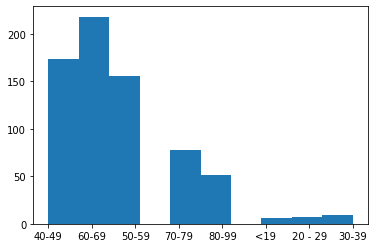

In [ ]:
plt.hist(data['age_groups'])

In [ ]:
data['age_groups'].value_counts()

60-69      218
40-49      173
50-59      156
70-79       78
80-99       51
30-39        9
20 - 29      7
<19          6
Name: age_groups, dtype: int64

#### Image augmentation and data Generation

##### Generator

In [ ]:
#This is a function that will shuffle the data after it has been split into training and test groups


def sample_df(df, col_name='family', n_sample_per_class=120, replace = False):
  samples = df.groupby(col_name)
  list_cls = df[col_name].unique()
  df_lst = []
  for cls in list_cls:
      cls_df = samples.get_group(cls)
      if (cls_df.shape[0] < n_sample_per_class) and (replace==False):
        cls_sample = cls_df
      else:
        cls_sample = cls_df.sample(n=n_sample_per_class,replace=replace,random_state=42)
      df_lst.append(cls_sample)
  df_sampled = pd.concat(df_lst, sort=False)
  df_sampled = shuffle(df_sampled)

  return df_sampled

This data generator is made up of several functions. The first is to split the data into train, test and validation sets. The next is a function that does image pre-processing on the training images (needed for a more diverse training set). This step is necessary for data augmentation. The final function generates the images, including data for age, sex, tooth code and eruption.

In [ ]:
#This is a data generator that will load the image, as well as important information (sex, tooth code, and eruption) into one group, and the correct age in another group.
class ToothdataGenerator():
    """
   This is a data generator for the Teeth dataset, adapted from the code used in this article: https://towardsdatascience.com/building-a-multi-output-convolutional-neural-network-with-keras-ed24c7bc1178
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self, random_state= 1313):
        p = np.random.RandomState(seed= random_state).permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]
        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        
        return train_idx, valid_idx, test_idx



#Now to preprocess and generate the images

    def preprocess_image(self, img_path, IMG_SIZE = 224, training = False):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = tf.keras.preprocessing.image.load_img(img_path)
        im = im.resize((IMG_SIZE, IMG_SIZE))
        if training == True:
          img_contr_obj=ImageEnhance.Contrast(im)
          img_sharp_obj=ImageEnhance.Sharpness(im)
          factor=2.5
          im=img_contr_obj.enhance(factor)
          im = img_sharp_obj.enhance(factor)
          im = np.array(im).astype(np.float32) / 255.0
          im = tf.keras.preprocessing.image.random_brightness(im, brightness_range=(0.9, 1.1))
          im = tf.keras.preprocessing.image.random_shear(im, intensity= 0.00005)
          im = tf.keras.preprocessing.image.random_zoom(im, (0.9, 1.1))
        else:
          im = np.array(im).astype(np.float32) / 255.0
        return im
        
    def generate_images(self, image_idx, is_training, sampling, image_aug = False, batch_size=16, IMG_SIZE = 224):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, tooth_codes, gender, ages, eruptions = [], [], [], [], []
        #This next section will upsample teh 
        if sampling:
            sample = self.df.iloc[image_idx]
            sampled = sample_df(sample, 
                    'age_groups',
                    n_sample_per_class= int(sample['age_groups'].value_counts().median()),
                    replace = True
                    )
            sampled.reset_index(inplace= True)
            image_idx = sampled.index
        else:
          sampled = self.df.iloc[image_idx]
          sampled.reset_index(inplace= True)
          image_idx =  sampled.index
        while True:
          
          for idx in image_idx:
                slice = sampled.iloc[idx]
                
                age = slice['Age']
                tooth_code = slice['Tooth.Code']
                sex = slice['Sex']
                image = slice['ImgName']
                erupt = slice['eruption']
                
                im = self.preprocess_image(image_dir + image, IMG_SIZE = IMG_SIZE, training = image_aug)
                
                ages.append(age)
                tooth_codes.append(tooth_code)
                gender.append(sex)
                images.append(im)
                eruptions.append(erupt)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield [np.array(images),[np.array(gender),np.array(tooth_codes), np.array(eruptions)]] , np.array(ages)
                    images, tooth_codes, gender, eruption_age, ages, eruptions = [], [], [], [], [], []
                    
          if not is_training:
                break


##### Testing image generation

In [ ]:
TRAIN_TEST_SPLIT = 0.75
data_generator = ToothdataGenerator(data)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

In [ ]:
print(len(train_idx), len(valid_idx), len(test_idx))

392 131 175


#### Model creation

In [ ]:
conv_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=(224,224,3),
                                                  include_top=False,
                                                  weights = "imagenet"
                                                        )
conv_model.trainable = True
model_multi = Sequential()
model_multi.add(conv_model)
model_multi.add(tf.keras.layers.Dropout(0.2))
model_multi.add(tf.keras.layers.GlobalAveragePooling2D())
model_multi.add(tf.keras.layers.Dense(1, activation = None))

94674944/94668760 [==============================] - 3s 0us/step


In [ ]:
checkpoint_filepath = project_dir + 'models/checkpoint_multi_input_cleaned_images.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/models/checkpoint_multi_cropped_imagesonly.ckpt


In [ ]:
model_multi.load_weights(latest)

In [ ]:
model_multi.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
#Loss function needs to be the Mean_squared error
loss = "MeanSquaredError"

#metrics for measurement
metrics = ['RootMeanSquaredError']

#Optimizer is going to the Adam, because it is the best performing
Optimizer = Adam(learning_rate= 1e-5)

In [ ]:
model_multi.compile(optimizer= Optimizer, loss = loss, metrics= metrics)

Currently, epochs is set to 50 and early stopping is set to stop after 5 epochs of no improvement. Early stopping can be removed if time is not a limiting factor. It's also recommended to increase the number of epochs due to the complex nature of the images.

In [ ]:
#model checkpoint
checkpoint_filepath = project_dir + 'models/checkpoint_multi_input_cleaned_images.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)
#EarlyStopping - currently patience is set to 5, this can be changed to give the model more time
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_root_mean_squared_error",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
#Reduce LR on Plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=1e-7)
#CSV Logger
csv_logger = tf.keras.callbacks.CSVLogger(project_dir + "logs/training_combined.log", append = True)

epochs = 50
callbacks = [reduce_lr, csv_logger, early_stop, checkpoint]

#### Full dataset model

Note: Due to the complexity of the images, a large number of epochs is needed with consistent access to GPUs.

In [ ]:
batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_images(train_idx, is_training=True, sampling= True, image_aug= True, batch_size=batch_size, IMG_SIZE = 224)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, sampling = False, batch_size=valid_batch_size, IMG_SIZE= 224)

In [ ]:
history = model_multi.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size
                    )

Epoch 1/50
12/12 [==============================] - 124s 10s/step - loss: 3057.9197 - root_mean_squared_error: 55.2985 - val_loss: 3812.8135 - val_root_mean_squared_error: 61.7480
Epoch 2/50
12/12 [==============================] - 24s 2s/step - loss: 2948.3777 - root_mean_squared_error: 54.2990 - val_loss: 3768.0920 - val_root_mean_squared_error: 61.3848
Epoch 3/50
12/12 [==============================] - 24s 2s/step - loss: 2908.9050 - root_mean_squared_error: 53.9343 - val_loss: 3747.3950 - val_root_mean_squared_error: 61.2160
Epoch 4/50
12/12 [==============================] - 24s 2s/step - loss: 2699.8604 - root_mean_squared_error: 51.9602 - val_loss: 3703.8823 - val_root_mean_squared_error: 60.8595
Epoch 5/50
12/12 [==============================] - 24s 2s/step - loss: 2706.1848 - root_mean_squared_error: 52.0210 - val_loss: 3685.3679 - val_root_mean_squared_error: 60.7072
Epoch 6/50
12/12 [==============================] - 25s 2s/step - loss: 2376.0432 - root_mean_squared_error:

##### Evaulate results

In [ ]:
results_df = pd.DataFrame(history.history)
results_df.head()

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,lr
0,3057.919678,55.298458,3812.813477,61.747982,0.00001
1,2948.377686,54.298965,3768.092041,61.384789,0.00001
2,2908.905029,53.934265,3747.395020,61.215969,0.00001
3,2699.860352,51.960182,3703.882324,60.859528,0.00001
4,2706.184814,52.021004,3685.367920,60.707230,0.00001


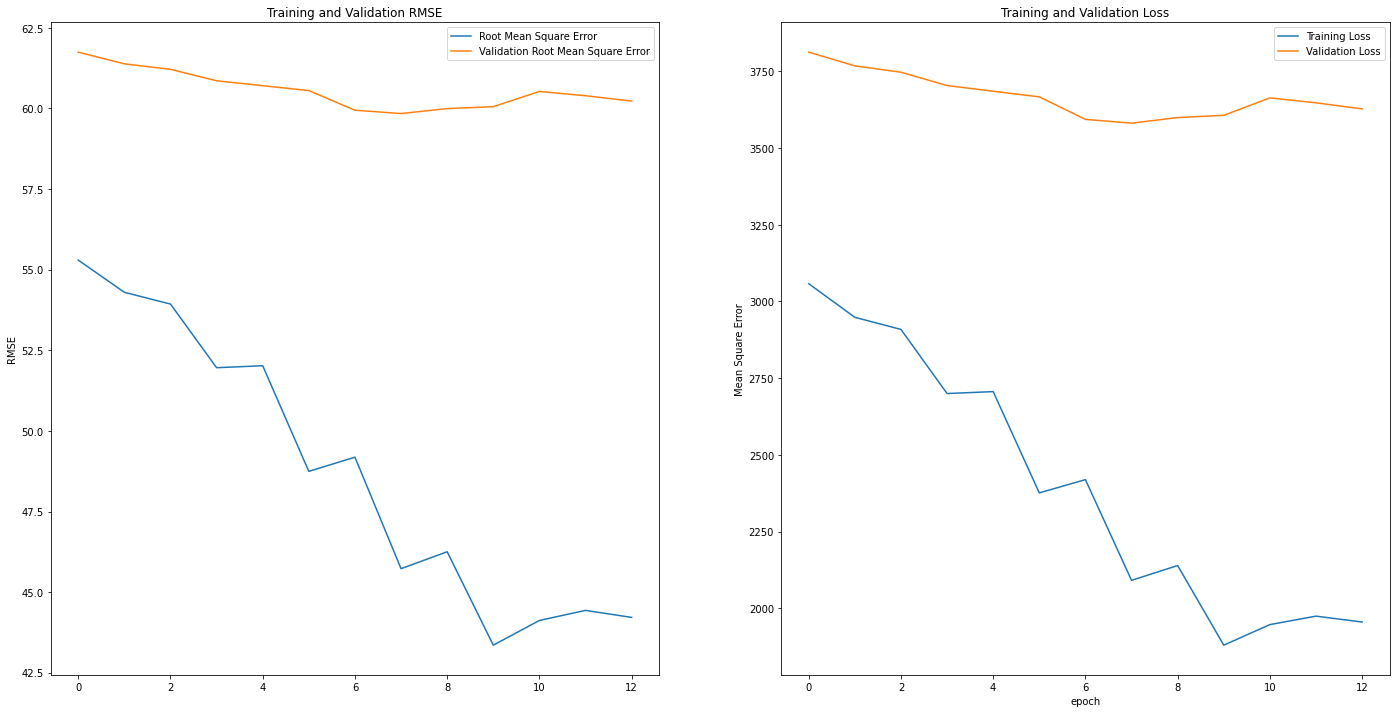

In [ ]:
plt.figure(figsize=(24, 12), facecolor= 'w')
plt.subplot(1, 2, 1)
plt.plot(results_df['root_mean_squared_error'], label='Root Mean Square Error')
plt.plot(results_df['val_root_mean_squared_error'], label='Validation Root Mean Square Error')
plt.legend(loc='upper right')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(results_df['loss'], label='Training Loss')
plt.plot(results_df['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Mean Square Error')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
test_batch_size = 1
test_generator = data_generator.generate_images(test_idx, is_training=False,sampling=False, batch_size=test_batch_size)

In [ ]:
score = model_multi.evaluate(test_generator, verbose = 1)

175/175 [==============================] - 83s 473ms/step - loss: 3713.4924 - root_mean_squared_error: 60.9384


In [ ]:
pred = model_multi.predict(test_generator, steps=len(test_idx)//test_batch_size)

In [ ]:
fig = plt.gcf()
sns.set_style("darkgrid")
fig.set_size_inches(20, 12)
test_labels = data.iloc[test_idx]
ax = sns.scatterplot(x = test_labels['Age'], y = pred.flatten(), edgecolor = 'w', s = 80,)
ax.set(xlabel='True Age', ylabel='Predicted Age', title = "True Age vs Predicted Age")

NameError: ignored

<Figure size 1440x864 with 0 Axes>